In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import calendar
from datetime import date

%run ../db.py
%run ../database.py
%run ../utils.py


In [ ]:
cgreen = '#27ae60'
cblue = '#2980b9'
cred = '#c0392b'
corange = '#d35400'
cgrey = '#7f8c8d'
cdark = '#2c3e50'
cwithe = '#ecf0f1'

figsize = (10, 6)

limite_suplementacao_loa = 0.15

In [ ]:
spec = {
    'data_base': 'Mês',
    'arrecadado': 'Arrecadado',
    'empenhado': 'Empenhado',
    'liquidado': 'Liquidado',
    'dif_arrec_emp': 'Empenhado / Arrecadado',
    'dif_arrec_liq': 'Liquidado / Arrecadado'
}
fmt = {
    'data_base': date_to_month_name,
    'arrecadado': money_formatter,
    'empenhado': money_formatter,
    'liquidado': money_formatter,
    'dif_arrec_emp': perc0_formatter,
    'dif_arrec_liq': perc0_formatter
}

In [ ]:
def plot_acumulado(df, titulo):
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(titulo, x=0, fontsize=16)
    plt.title('valores acumulados', x=0)
    x = df['data_base'].dt.strftime('%b')
    plt.plot(x, df['arrecadado'], color=cgreen, label='Arrecadado', marker='o')
    plt.plot(x, df['empenhado'], color=cred, label='Empenhado', marker='s')
    plt.plot(x, df['liquidado'], color=corange, label='Liquidado', marker='^')
    plt.ylim(bottom=0)
    ax.yaxis.set_major_formatter(int_formatter)
    plt.xticks(x)
    plt.legend(loc='best', ncol=3)
    plt.show()

def adiciona_data_base(df):
    last_day_of_month = []
    for month in range(df['data_base'].max().month + 1, 13):
        last_day_of_month.append(date(df['data_base'].max().year, month, calendar.monthrange(df['data_base'].max().year, month)[1]))
    for dt in last_day_of_month:
        n = pd.DataFrame([{'data_base': dt}])
        df = pd.concat([df, n])
    df = df.reset_index(drop=True)
    return df


# Receitas x Despesas

Nesta parte são copmradas as receitas e despesas da **Prefeitura**, excluídas, portanto, as receias do *RPPS*. Também são excluídas as receitas *intra-orçamentárias*.

As receitas são apresentadas em seus valores líquidos das deduções da receita.

## Receita Total x Despesa Total

In [ ]:
nome = 'Receita Total x Despesa Total'
sql = f'''
WITH d AS (
	SELECT
		data_final AS data_base,
		0.0 AS arrecadado,
		SUM(valor_empenhado) AS empenhado,
		SUM(valor_liquidado) AS liquidado
	FROM
		pad."BAL_DESP"
	WHERE
		entidade LIKE 'pm'
		AND controle BETWEEN {controle_ano}01 AND {controle_mes}
	GROUP BY
		data_base
	ORDER BY
		data_base ASC
), r AS (
	SELECT
		data_final AS data_base,
		SUM(receita_realizada) AS arrecadado,
		0.0 AS empenhado,
		0.0 AS liquidado
	FROM
		pad."BAL_REC"
	WHERE
		entidade LIKE 'pm'
		AND controle BETWEEN {controle_ano}01 AND {controle_mes}
		AND classe_receita NOT LIKE 'intra'
	GROUP BY
		data_base
	ORDER BY
		data_base ASC
), t AS (SELECT * FROM r UNION SELECT * FROM d)
SELECT data_base, SUM(arrecadado) AS arrecadado, SUM(empenhado) AS empenhado, SUM(liquidado) AS liquidado FROM t GROUP BY data_base ORDER BY data_base ASC
'''
#print(sql)
orcamento = sqldf(sql)
orcamento['dif_arrec_emp'] = orcamento['empenhado'] / orcamento['arrecadado']
orcamento['dif_arrec_liq'] = orcamento['liquidado'] / orcamento['arrecadado']
orcamento = adiciona_data_base(orcamento)
orcamento['data_base'] = pd.to_datetime(orcamento['data_base'], format='%Y-%m-%d')
#orcamento

In [ ]:
plot_acumulado(orcamento.copy(), nome)

In [ ]:
df = df_table(orcamento.copy(), spec, fmt)
df.style.set_caption(f'{nome} - valores acumulados - {dt.year}').hide(axis='index')
#df

## Receita Corrente x Despesa Corrente

In [ ]:
nome = 'Receita Corrente x Despesa Corrente'
sql = f'''
WITH d AS (
	SELECT
		data_final AS data_base,
		0.0 AS arrecadado,
		SUM(valor_empenhado) AS empenhado,
		SUM(valor_liquidado) AS liquidado
	FROM
		pad."BAL_DESP"
	WHERE
		entidade LIKE 'pm'
		AND controle BETWEEN {controle_ano}01 AND {controle_mes}
        AND elemento LIKE '3%%'
	GROUP BY
		data_base
	ORDER BY
		data_base ASC
), r AS (
	SELECT
		data_final AS data_base,
		SUM(receita_realizada) AS arrecadado,
		0.0 AS empenhado,
		0.0 AS liquidado
	FROM
		pad."BAL_REC"
	WHERE
		entidade LIKE 'pm'
		AND controle BETWEEN {controle_ano}01 AND {controle_mes}
		AND classe_receita NOT LIKE 'intra'
        AND receita_base LIKE '1%%'
	GROUP BY
		data_base
	ORDER BY
		data_base ASC
), t AS (SELECT * FROM r UNION SELECT * FROM d)
SELECT data_base, SUM(arrecadado) AS arrecadado, SUM(empenhado) AS empenhado, SUM(liquidado) AS liquidado FROM t GROUP BY data_base ORDER BY data_base ASC
'''
#print(sql)
orcamento = sqldf(sql)
orcamento['dif_arrec_emp'] = orcamento['empenhado'] / orcamento['arrecadado']
orcamento['dif_arrec_liq'] = orcamento['liquidado'] / orcamento['arrecadado']
orcamento = adiciona_data_base(orcamento)
orcamento['data_base'] = pd.to_datetime(orcamento['data_base'], format='%Y-%m-%d')
#orcamento

In [ ]:
plot_acumulado(orcamento.copy(), nome)

In [ ]:
df = df_table(orcamento.copy(), spec, fmt)
df.style.set_caption(f'{nome} - valores acumulados - {dt.year}').hide(axis='index')
#df

## Receita Corrente x Despesa com Pessoal e Encargos Sociais

In [ ]:
nome = 'Receita Corrente x Despesa com Pessoal e Encargos Sociais'
sql = f'''
WITH d AS (
	SELECT
		data_final AS data_base,
		0.0 AS arrecadado,
		SUM(valor_empenhado) AS empenhado,
		SUM(valor_liquidado) AS liquidado
	FROM
		pad."BAL_DESP"
	WHERE
		entidade LIKE 'pm'
		AND controle BETWEEN {controle_ano}01 AND {controle_mes}
        AND elemento LIKE '31%%'
	GROUP BY
		data_base
	ORDER BY
		data_base ASC
), r AS (
	SELECT
		data_final AS data_base,
		SUM(receita_realizada) AS arrecadado,
		0.0 AS empenhado,
		0.0 AS liquidado
	FROM
		pad."BAL_REC"
	WHERE
		entidade LIKE 'pm'
		AND controle BETWEEN {controle_ano}01 AND {controle_mes}
		AND classe_receita NOT LIKE 'intra'
        AND receita_base LIKE '1%%'
	GROUP BY
		data_base
	ORDER BY
		data_base ASC
), t AS (SELECT * FROM r UNION SELECT * FROM d)
SELECT data_base, SUM(arrecadado) AS arrecadado, SUM(empenhado) AS empenhado, SUM(liquidado) AS liquidado FROM t GROUP BY data_base ORDER BY data_base ASC
'''
#print(sql)
orcamento = sqldf(sql)
orcamento['dif_arrec_emp'] = orcamento['empenhado'] / orcamento['arrecadado']
orcamento['dif_arrec_liq'] = orcamento['liquidado'] / orcamento['arrecadado']
orcamento = adiciona_data_base(orcamento)
orcamento['data_base'] = pd.to_datetime(orcamento['data_base'], format='%Y-%m-%d')
#orcamento

In [ ]:
plot_acumulado(orcamento.copy(), nome)

In [ ]:
df = df_table(orcamento.copy(), spec, fmt)
df.style.set_caption(f'{nome} - valores acumulados - {dt.year}').hide(axis='index')
#df

## Suplementação Autorizada na LOA

In [ ]:
nome = 'Suplementação Autorizada na LOA'
sql = f'''
WITH disponivel AS (
	SELECT
		data_final AS data_base,
		SUM(saldo_final) AS vldisponivel,
		0.0 AS vlutilizado
	FROM
		pad."BAL_VER"
	WHERE
		entidade LIKE 'pm'
		AND controle BETWEEN {controle_ano}01 AND {controle_ano}12
		AND conta_contabil LIKE '899940101%%'
	GROUP BY
		data_base
	ORDER BY
		data_base ASC
), utilizado AS (
	SELECT
		data_final AS data_base,
		0.0 AS vldisponivel,
		SUM(saldo_final) AS vlutilizado
	FROM
		pad."BAL_VER"
	WHERE
		entidade LIKE 'pm'
		AND controle BETWEEN {controle_ano}01 AND {controle_ano}12
		AND conta_contabil LIKE '899940102%%'
	GROUP BY
		data_base
	ORDER BY
		data_base ASC
), total AS (
	SELECT * FROM disponivel UNION ALL SELECT * FROM utilizado
)
SELECT
	data_base,
	SUM(vldisponivel) AS disponivel,
	SUM(vlutilizado) AS utilizado,
	(SUM(vldisponivel) + SUM(vlutilizado)) AS total
FROM total
GROUP BY data_base
ORDER BY data_base ASC;'''
#print(sql)

limite = sqldf(sql)
limite = adiciona_data_base(limite)
limite['data_base'] = pd.to_datetime(limite['data_base'], format='%Y-%m-%d')
limite_atual = limite[limite['data_base'] == dt]['total'].sum()
limite['total'] = limite['total'].fillna(limite_atual)
limite['vl_esperado'] = None
limite['perc_esperado'] = None
limite['perc_utilizado'] = None
for i, r in limite.iterrows():
    mes = r['data_base'].month
    fracao_limite = round(r['total'] / 12 * mes)
    perc_fracao_limite = fracao_limite / r['total'] * limite_suplementacao_loa
    limite.at[i, 'vl_esperado'] = fracao_limite
    limite.at[i, 'perc_esperado'] = perc_fracao_limite
    limite.at[i, 'perc_utilizado'] = r['utilizado'] / r['total'] * limite_suplementacao_loa
#limite

In [ ]:
df = limite.copy()
fig, ax = plt.subplots(figsize=figsize)
fig.suptitle(nome, x=0, fontsize=16)
x = df['data_base'].dt.strftime('%b')
plt.plot(x, df['total'], color=cgrey, label='Autorizado', linestyle='--')
plt.plot(x, df['vl_esperado'], color=corange, label='Esperado')
plt.bar(x, df['disponivel'], color=cgreen, label='Disponível')
plt.bar(x, df['utilizado'], color=cblue, label='Utilizado')
plt.ylim(bottom=0, top=ax.get_ylim()[1] * 1.2)
ax.yaxis.set_major_formatter(int_formatter)
plt.xticks(x)
plt.legend(loc='upper right', ncol=3)
plt.show()


In [ ]:
lspec = {
    'data_base': 'Mês',
    'total': 'Autorizado',
    'utilizado': 'Utilizado',
    'disponivel': 'Disponível',
    'perc_esperado': '% esperado',
    'perc_utilizado': '% utilizado'
}
lfmt = {
    'data_base': date_to_month_name,
    'total': money_formatter,
    'utilizado': money_formatter,
    'disponivel': money_formatter,
    'perc_esperado': perc2_formatter,
    'perc_utilizado': perc2_formatter
}
df = df_table(limite.copy(), lspec, lfmt)
df.style.set_caption(f'{nome} - {dt.year}').hide(axis='index')

## Dotação e Execução do Orçamento

### Dotação e Saldos por Órgão

In [135]:
nome = 'Dotação e Saldos por Órgão'
sql = f'''
SELECT
	nome_orgao,
	SUM(valor_empenhado) AS empenhado,
	SUM(dotacao_a_empenhar) AS saldo
FROM
	pad."BAL_DESP"
WHERE
	entidade LIKE 'pm'
	AND controle = {controle_mes}
GROUP BY
	nome_orgao
ORDER BY
	(SUM(valor_empenhado) + SUM(dotacao_a_empenhar)) DESC;'''
#print(sql)

orcamento = sqldf(sql)
orcamento['total'] = orcamento['empenhado'] + orcamento['saldo']
orcamento['perc_emp'] = orcamento['empenhado'] / orcamento['total']
#orcamento

,nome_orgao,empenhado,saldo,total,perc_emp
0,SECRETARIA DE EDUCACAO CULTURA DESPORTO E TURISMO,6013063.96,6845332.42,12858396.38,0.467637
1,SECRETARIA MUNICIPAL DE SAUDE,4567982.64,4113143.99,8681126.63,0.526197
2,SECRETARIA DE SERVICOS URBANOS E TRANSITO,1613343.80,2340545.06,3953888.86,0.408040
3,SECRETARIA DE OBRAS E VIACAO,1752573.21,1605068.77,3357641.98,0.521965
4,SECRETARIA DA AGRICULTURA E ABASTECIMENTO,1148862.08,1092818.14,2241680.22,0.512500
5,SECRETARIA DA FAZENDA,685575.74,1172731.26,1858307.00,0.368925
6,SECRETARIA DA ASSISTENCIA SOCIAL,695750.20,1117995.61,1813745.81,0.383599
7,SECRETARIA DE ADMINISTRACAO,640983.03,1084881.97,1725865.00,0.371398
8,GABINETE DO PREFEITO E VICE PREFEITO,666845.02,456314.98,1123160.00,0.593722
9,ENCARGOS ESPECIAIS,709661.09,307629.85,1017290.94,0.697599


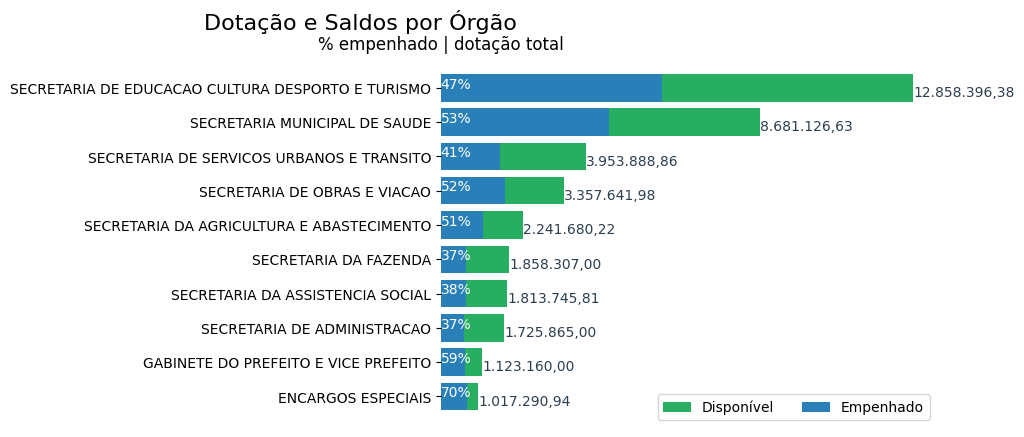

In [131]:
fig, ax = plt.subplots()
fig.suptitle(nome, x=0, fontsize=16)
plt.title('% empenhado | dotação total', x=0)
orgaos = orcamento['nome_orgao']
ax.barh(orgaos, orcamento['total'], color=cgreen, label='Disponível')
ax.barh(orgaos, orcamento['empenhado'], color=cblue, label='Empenhado')
ax.invert_yaxis()
for i, v in enumerate(orcamento['total']):
    ax.text(v + 3, i + 0.25, money_formatter(v), color=cdark)
    
for i, v in enumerate(orcamento['perc_emp']):
    ax.text(v, i, perc0_formatter(v), color='w')

ax.set_xticks([])
ax.set_frame_on(False)
plt.legend(loc='lower right', ncol=2)
plt.show()

In [136]:
lspec = {
    'nome_orgao': 'Órgão',
    'total': 'Dotação',
    'empenhado': 'Empenhado',
    'saldo': 'Disponível',
    'perc_emp': '% empenhado'
}
lfmt = {
    'total': money_formatter,
    'saldo': money_formatter,
    'empenhado': money_formatter,
    'perc_emp': perc0_formatter
}
df = df_table(orcamento.copy(), lspec, lfmt)
df.style.set_caption(f'{nome} - {dt.year}').hide(axis='index')

Órgão,Dotação,Empenhado,Disponível,% empenhado
SECRETARIA DE EDUCACAO CULTURA DESPORTO E TURISMO,"12.858.396,38","6.013.063,96","6.845.332,42",47%
SECRETARIA MUNICIPAL DE SAUDE,"8.681.126,63","4.567.982,64","4.113.143,99",53%
SECRETARIA DE SERVICOS URBANOS E TRANSITO,"3.953.888,86","1.613.343,80","2.340.545,06",41%
SECRETARIA DE OBRAS E VIACAO,"3.357.641,98","1.752.573,21","1.605.068,77",52%
SECRETARIA DA AGRICULTURA E ABASTECIMENTO,"2.241.680,22","1.148.862,08","1.092.818,14",51%
SECRETARIA DA FAZENDA,"1.858.307,00","685.575,74","1.172.731,26",37%
SECRETARIA DA ASSISTENCIA SOCIAL,"1.813.745,81","695.750,20","1.117.995,61",38%
SECRETARIA DE ADMINISTRACAO,"1.725.865,00","640.983,03","1.084.881,97",37%
GABINETE DO PREFEITO E VICE PREFEITO,"1.123.160,00","666.845,02","456.314,98",59%
ENCARGOS ESPECIAIS,"1.017.290,94","709.661,09","307.629,85",70%
